# Build Sentinel-2 Data Cubes

This notebook demonstrates how to construct 3D data cubes from multiple Sentinel-2 tiles using [**xcube-eopf**](https://github.com/EOPF-Sample-Service/xcube-eopf). The following steps are performed by **xcube-eopf** to generate the data cubes:

- **Query tiles**: Identify relevant Sentinel-2 tiles based on a spatiotemporal search using the [EOPF Zarr Sample Service STAC API](https://stac.core.eopf.eodc.eu).
- **Group by tile and date**: Organize STAC items by MGRS tile ID and solar day.
- **Spatial mosaicking**: Merge adjacent tiles acquired on the same day into seamless scenes.
- **Time stacking**: Combine daily mosaics along the time dimension to form 3D data cubes for each data variable (e.g., spectral bands).


In [1]:
from xcube.core.store import new_data_store
from xcube_resampling.utils import reproject_bbox
import xarray as xr

In [2]:
xr.set_options(display_expand_attrs=False)

To initialize an `eopf-zarr` [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework), execute the cell below:

In [3]:
store = new_data_store("eopf-zarr")

The data IDs point to [STAC collections](https://stac.browser.user.eopf.eodc.eu). In the following cell we can list the available data IDs.

In [4]:
store.list_data_ids()

['sentinel-2-l1c',
 'sentinel-2-l2a',
 'sentinel-3-olci-l1-efr',
 'sentinel-3-olci-l2-lfr',
 'sentinel-3-slstr-l1-rbt',
 'sentinel-3-slstr-l2-lst']

Below, the parameters for the `open_data` method can be viewed for each supported data product.

In [5]:
store.get_open_data_params_schema()

This function also shows opening parameters for a specific `data_id`, as shown below. 

In [6]:
store.get_open_data_params_schema(data_id="sentinel-2-l2a")

We now want to generate a data cube from the Sentinel-2 L2A product. We therefore assign `data_id` to `"sentinel-2-l2a"`. We set the bounding box to cover the greater Hamburg area and the time range to the first half of Mai 2025. We first want to get the datacube in the native UTM projection. 

In [7]:
bbox = [9.7, 53.4, 10.3, 53.7]
crs_utm = "EPSG:32632"
bbox_utm = reproject_bbox(bbox, "EPSG:4326", crs_utm)

In [8]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm,
    time_range=["2025-05-01", "2025-05-07"],
    spatial_res=10,
    crs=crs_utm,
    variables=["b02", "b03", "b04", "scl"],
)
ds

CPU times: user 787 ms, sys: 47.5 ms, total: 834 ms
Wall time: 12.4 s


<xarray.Dataset> Size: 1GB
Dimensions:      (time: 3, y: 3394, x: 4023)
Coordinates:
  * time         (time) datetime64[ns] 24B 2025-05-01T10:40:41.025000 ... 202...
    spatial_ref  int64 8B ...
  * x            (x) float64 32kB 5.462e+05 5.462e+05 ... 5.864e+05 5.864e+05
  * y            (y) float64 27kB 5.951e+06 5.951e+06 ... 5.917e+06 5.917e+06
Data variables:
    b02          (time, y, x) float64 328MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03          (time, y, x) float64 328MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04          (time, y, x) float64 328MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    scl          (time, y, x) uint8 41MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
Attributes: (4)

CPU times: user 603 ms, sys: 266 ms, total: 869 ms
Wall time: 2.4 s


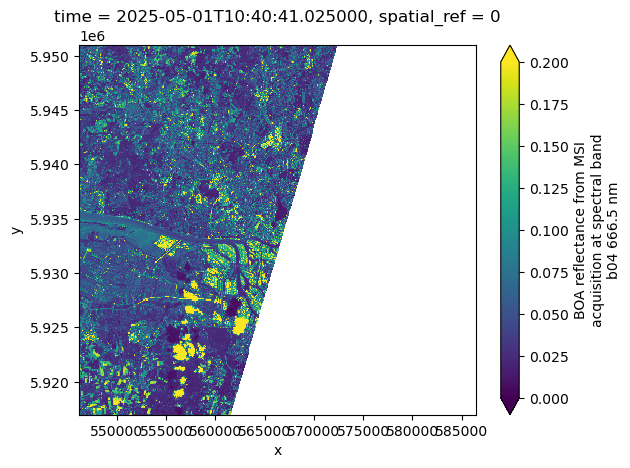

In [9]:
%%time
ds.b04.isel(time=0)[::10, ::10].plot(vmin=0, vmax=0.2)

The user can also set `crs="native"` which allows specifying the bounding box in latitude/longitude, but returns the data in UTM. Note if the data request covers multiple UTM zones, an error will be raised. 

In [10]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox,
    time_range=["2025-05-01", "2025-05-07"],
    spatial_res=10,
    crs="native",
    variables=["b02", "b03", "b04", "scl"],
)
ds

CPU times: user 1 s, sys: 32.3 ms, total: 1.03 s
Wall time: 7.53 s


<xarray.Dataset> Size: 1GB
Dimensions:      (time: 3, y: 3394, x: 4023)
Coordinates:
  * time         (time) datetime64[ns] 24B 2025-05-01T10:40:41.025000 ... 202...
    spatial_ref  int64 8B ...
  * x            (x) float64 32kB 5.462e+05 5.462e+05 ... 5.864e+05 5.864e+05
  * y            (y) float64 27kB 5.951e+06 5.951e+06 ... 5.917e+06 5.917e+06
Data variables:
    b02          (time, y, x) float64 328MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03          (time, y, x) float64 328MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04          (time, y, x) float64 328MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    scl          (time, y, x) uint8 41MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
Attributes: (4)

Now we can request the same data cube but in geographic projection ("EPSG:4326"). xcube-eopf can reproject the datacube to any projection requested by the user.

In [11]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox,
    time_range=["2025-05-01", "2025-05-07"],
    spatial_res=10 / 111320,  # meters converted to degrees (approx.)
    crs="EPSG:4326",
    variables=["b02", "b03", "b04", "scl"],
)

ds

CPU times: user 935 ms, sys: 24.8 ms, total: 960 ms
Wall time: 8.33 s


<xarray.Dataset> Size: 2GB
Dimensions:      (time: 3, lon: 6680, lat: 3340)
Coordinates:
  * time         (time) datetime64[ns] 24B 2025-05-01T10:40:41.025000 ... 202...
    spatial_ref  int64 8B 0
  * lon          (lon) float64 53kB 9.7 9.7 9.7 9.7 9.7 ... 10.3 10.3 10.3 10.3
  * lat          (lat) float64 27kB 53.7 53.7 53.7 53.7 ... 53.4 53.4 53.4 53.4
Data variables:
    b02          (time, lat, lon) float64 535MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03          (time, lat, lon) float64 535MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04          (time, lat, lon) float64 535MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    scl          (time, lat, lon) uint8 67MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
Attributes: (4)

CPU times: user 12.4 s, sys: 2.93 s, total: 15.3 s
Wall time: 3.17 s


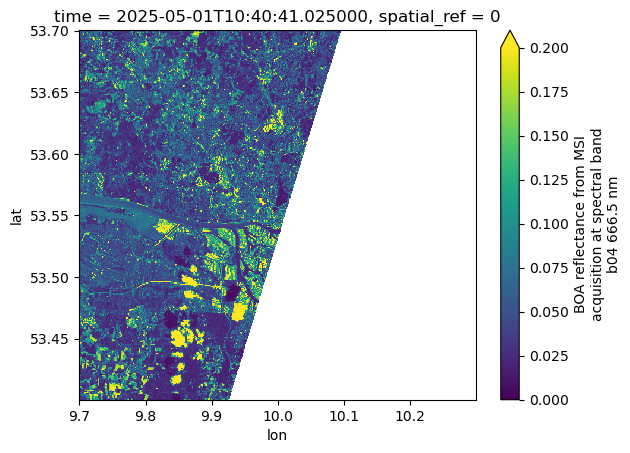

In [12]:
%%time
ds.b04.isel(time=0)[::10, ::10].plot(vmin=0, vmax=0.2)

We now want to generate a similar data cube from the Sentinel-2 L1C product. We therefore assign `data_id` to `"sentinel-2-l1c"`.

In [13]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l1c",
    bbox=bbox_utm,
    time_range=["2025-08-15", "2025-08-22"],
    spatial_res=10,
    crs=crs_utm,
    variables=["b02", "b03", "b04"],
)
ds

CPU times: user 868 ms, sys: 31.8 ms, total: 899 ms
Wall time: 11.1 s


<xarray.Dataset> Size: 1GB
Dimensions:      (time: 4, y: 3394, x: 4023)
Coordinates:
  * time         (time) datetime64[ns] 32B 2025-08-16T10:30:41.025000 ... 202...
    spatial_ref  int64 8B ...
  * x            (x) float64 32kB 5.462e+05 5.462e+05 ... 5.864e+05 5.864e+05
  * y            (y) float64 27kB 5.951e+06 5.951e+06 ... 5.917e+06 5.917e+06
Data variables:
    b02          (time, y, x) float64 437MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b03          (time, y, x) float64 437MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
    b04          (time, y, x) float64 437MB dask.array<chunksize=(1, 1830, 1830), meta=np.ndarray>
Attributes: (4)

CPU times: user 1.5 s, sys: 724 ms, total: 2.22 s
Wall time: 12.4 s


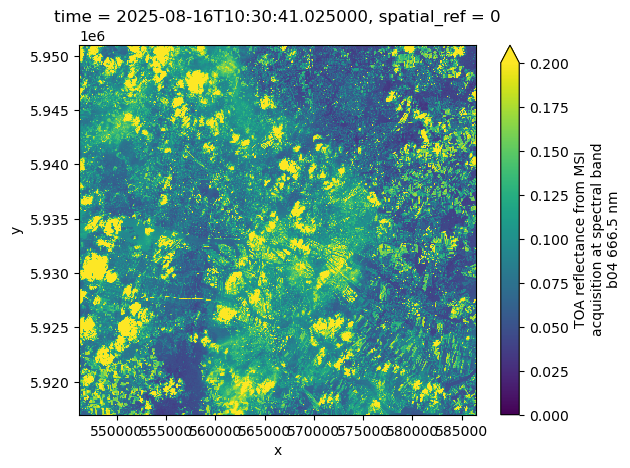

In [14]:
%%time
ds.b04.isel(time=0)[::10, ::10].plot(vmin=0, vmax=0.2)